In [1]:
import torch
import pickle
import pandas as pd
import os
from PIL import Image, ImageOps
import numpy as np
from utils import normalize_rgb, render_meshes, get_focalLength_from_fieldOfView, demo_color as color, print_distance_on_image, render_side_views, create_scene, MEAN_PARAMS, CACHE_DIR_MULTIHMR, SMPLX_DIR
from model import Model

torch.cuda.empty_cache()
device = torch.device('cuda')

# Functions from demo.py

In [2]:
def open_image(img_path, img_size, device=torch.device('cuda')):
    """ Open image at path, resize and pad """
    Image.MAX_IMAGE_PIXELS = None

    # Open and reshape
    img_pil = Image.open(img_path).convert('RGB')
    img_pil = ImageOps.contain(img_pil, (img_size,img_size)) # keep the same aspect ratio

    # Keep a copy for visualisations.
    img_pil_bis = ImageOps.pad(img_pil.copy(), size=(img_size,img_size), color=(255, 255, 255))
    img_pil = ImageOps.pad(img_pil, size=(img_size,img_size)) # pad with zero on the smallest side

    # Go to numpy 
    resize_img = np.asarray(img_pil)

    # Normalize and go to torch. MODIFIED TO NOT GOT TO TORCH
    resize_img = normalize_rgb(resize_img)
    x = np.expand_dims(resize_img, axis=0)
    return x, img_pil_bis

def load_model(model_name, device=torch.device('cuda')):
    """ Open a checkpoint, build Multi-HMR using saved arguments, load the model weigths. """
    # Model
    ckpt_path = os.path.join(CACHE_DIR_MULTIHMR, model_name+ '.pt')
    if not os.path.isfile(ckpt_path):
        os.makedirs(CACHE_DIR_MULTIHMR, exist_ok=True)
        print(f"{ckpt_path} not found...")
        print("It should be the first time you run the demo code")
        print("Downloading checkpoint from NAVER LABS Europe website...")
        
        try:
            os.system(f"wget -O {ckpt_path} https://download.europe.naverlabs.com/ComputerVision/MultiHMR/{model_name}.pt")
            print(f"Ckpt downloaded to {ckpt_path}")
        except:
            assert "Please contact fabien.baradel@naverlabs.com or open an issue on the github repo"

    # Load weights
    print("Loading model")
    ckpt = torch.load(ckpt_path, map_location=device)

    # Get arguments saved in the checkpoint to rebuild the model
    kwargs = {}
    for k,v in vars(ckpt['args']).items():
            kwargs[k] = v

    # Build the model.
    kwargs['type'] = ckpt['args'].train_return_type
    kwargs['img_size'] = ckpt['args'].img_size[0]
    model = Model(**kwargs).to(device)

    # Load weights into model.
    model.load_state_dict(ckpt['model_state_dict'], strict=False)
    print("Weights have been loaded")

    return model

def forward_model(model, input_image, camera_parameters,
                  det_thresh=0.3,
                  nms_kernel_size=1,
                 ):
        
    """ Make a forward pass on an input image and camera parameters. """
    
    # Forward the model.
    with torch.no_grad():
        with torch.cuda.amp.autocast(enabled=True):
            humans = model(input_image, 
                           is_training=True, 
                           nms_kernel_size=int(nms_kernel_size),
                           det_thresh=det_thresh,
                           K=camera_parameters)

    return humans

def get_camera_parameters(img_size, fov=60, p_x=None, p_y=None, device=torch.device('cuda')):
    """ Given image size, fov and principal point coordinates, return K the camera parameter matrix"""
    K = torch.eye(3)
    # Get focal length.
    focal = get_focalLength_from_fieldOfView(fov=fov, img_size=img_size)
    K[0,0], K[1,1] = focal, focal

    # Set principal point
    if p_x is not None and p_y is not None:
            K[0,-1], K[1,-1] = p_x * img_size, p_y * img_size
    else:
            K[0,-1], K[1,-1] = img_size//2, img_size//2

    # Add batch dimension
    K = K.unsqueeze(0).to(device)
    return K

def overlay_human_meshes(humans, K, model, img_pil, unique_color=False):

    # Color of humans seen in the image.
    _color = [color[0] for _ in range(len(humans))] if unique_color else color
    
    # Get focal and princpt for rendering.
    focal = np.asarray([K[0,0,0].cpu().numpy(),K[0,1,1].cpu().numpy()])
    princpt = np.asarray([K[0,0,-1].cpu().numpy(),K[0,1,-1].cpu().numpy()])

    # Get the vertices produced by the model.
    verts_list = [humans[j]['verts_smplx'].cpu().numpy() for j in range(len(humans))]
    faces_list = [model.smpl_layer['neutral'].bm_x.faces for j in range(len(humans))]

    # Render the meshes onto the image.
    pred_rend_array = render_meshes(np.asarray(img_pil), 
            verts_list,
            faces_list,
            {'focal': focal, 'princpt': princpt},
            alpha=1.0,
            color=_color)

    return pred_rend_array, _color


# Load Model

In [3]:
model = load_model('multiHMR_896_L')

Loading model


Using cache found in /home/scott/.cache/torch/hub/facebookresearch_dinov2_main
/home/scott/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/scott/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/scott/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


Weights have been loaded


# Load PANDA Dataset

In [4]:
with open("Panda.pkl", "rb") as file:
    data = pickle.load(file)

print(len(data[0]['params'][0]['betas']))

for key, value in data[0]["params"][0].items():
    print(key)

10
pose
betas
trans


In [5]:
# img_size = model.img_size
# train_x_path = "image_train"
# train_x = [] # images
# train_y = [] # ground truth
# i=0
# with open("Panda.pkl", "rb") as file:
#     data_list = pickle.load(file)
# for sub_dir, _, files in os.walk(train_x_path):
#     for filename in files:
#         if i == 10:
#             break
    
#         corresponding_dict = None
#         parent_folder = os.path.basename(sub_dir)
#         image_identifier = os.path.join(parent_folder, filename)
#         for data in data_list:
#             if os.path.join(os.path.basename(os.path.dirname(data["img_path"])), os.path.basename(data["img_path"])) == image_identifier:
#                 corresponding_dict = data
#                 break
#         if corresponding_dict == None:
#             print("problem")
#             print(image_identifier)
#             continue
#         file_path = os.path.join(sub_dir, filename)
#         x, img_pil_nopad = open_image(file_path, img_size)
#         train_x.append(x)
#         y = corresponding_dict['params']
#         train_y.append(np.array(y))
#         print(i)
#         i += 1
      
# assert len(train_x) == len(train_y)# Size of dataset

with open("panda/train_x.pkl", "rb") as f:
    train_x = pickle.load(f)
with open("panda/train_y.pkl", "rb") as f:
    train_y = pickle.load(f)

# Align Humans

In [6]:
# remove extra humans based on detection score
from copy import copy
def align_humans(predictions, gts):
    predictions = copy(predictions)
    gts = copy(gts)

    aligned_preds = []
    aligned_gts = []
    for pred, gt in zip(predictions, gts):
        while len(pred) > len(gt):
            det_scores = [person['scores'] for person in pred]
            min_value = min(det_scores, key=lambda x: x.item())
            index = det_scores.index(min_value)
            pred = pred[:index] + pred[index+1:]
        while len(pred) < len(gt):
            gt = gt[:len(gt)-1]
            
        assert len(pred) == len(gt)
        aligned_preds.append(pred)
        aligned_gts.append(gt)

    assert len(aligned_preds) == len(aligned_gts)
    return aligned_preds, aligned_gts


# SMPL Params loss

In [17]:
def smpl_params_loss(predictions, gts, fields, gt_fields):
    criterion = torch.nn.L1Loss()
    total_loss = 0

    for field, gt_field in zip(fields, gt_fields):
        preds = []
        curr_gts = []

        for humans in predictions:
            for human in humans:
                preds.append(human[field])


        for humans in gts:
            for human in humans:
                curr_gts.append(human[gt_field])

        # Convert to tensors
        preds = torch.stack(preds)
        curr_gts = torch.stack([torch.tensor(item).to(device) for item in curr_gts])

        preds, indices = torch.sort(preds)
        curr_gts, indices = torch.sort(curr_gts)

        if torch.isnan(preds).any():
            print("NaN detected in pred_humans_with_only_vertices after conversion")

        if torch.isnan(curr_gts).any():
            print("NaN detected in gts after conversion")

        loss = criterion(preds, curr_gts)
        total_loss += loss
        
        if torch.isnan(loss):
            print("NaN detected in the computed loss")
    return loss

## Test loss on small dataset

In [8]:
p_x, p_y = None, None
K = get_camera_parameters(model.img_size, fov=60, p_x=p_x, p_y=p_y)
small_output = []
small_y = []
for i in range(30):
     input = torch.from_numpy(train_x[i]).to(device)
     pred = forward_model(model, input, K,
                         det_thresh=0.3,
                         nms_kernel_size=1)
     small_output.append(pred)
     small_y.append(train_y[i])
#print(pred[0]['transl'])
#print(train_y[0][0]['trans'])

aligned_x, aligned_y = align_humans(small_output, small_y)
print(smpl_params_loss(aligned_x, aligned_y, ['transl'], ['trans']))

[[{'scores': tensor(0.3088, device='cuda:0', dtype=torch.float16), 'loc': tensor([752.8213, 408.5361], device='cuda:0'), 'transl': tensor([ 9.4453, -1.2217, 24.0299], device='cuda:0'), 'transl_pelvis': tensor([[ 9.4335, -0.6011, 24.0175]], device='cuda:0'), 'rotvec': tensor([[ 2.5616e+00, -4.6973e-02,  1.8146e+00],
        [ 1.1443e-02,  2.7383e-02, -1.8163e-02],
        [-5.4266e-02, -3.1330e-02, -8.5086e-04],
        [ 4.3752e-02, -2.8816e-02, -1.3511e-02],
        [ 4.9008e-02, -1.0432e-03, -9.7324e-03],
        [ 1.4674e-01, -4.1933e-02,  2.6072e-02],
        [-1.1401e-01, -2.1863e-02, -8.4445e-03],
        [ 4.6316e-02,  1.3380e-01, -8.8506e-02],
        [ 6.8408e-02, -1.7847e-01,  5.9155e-02],
        [ 1.0607e-01, -4.2168e-03, -3.2071e-02],
        [ 4.8260e-03,  1.0443e-02,  2.4529e-02],
        [ 3.4509e-02, -5.4088e-03, -3.2540e-02],
        [ 5.8294e-02,  1.7807e-02, -2.2167e-02],
        [ 1.1215e-02, -6.6440e-02, -9.5145e-02],
        [ 2.7330e-03,  4.8359e-02,  1.2683e-01

In [9]:
print(small_output[0][0]['transl'])

tensor([ 9.4453, -1.2217, 24.0299], device='cuda:0')


# Training

In [10]:
def print_computation_graph(tensor, indent=0):
    if hasattr(tensor, 'grad_fn') and tensor.grad_fn is not None:
        print(' ' * indent, tensor.grad_fn)
        for next_tensor in tensor.grad_fn.next_functions:
            print(next_tensor)
            if next_tensor[0] is not None:
                print_computation_graph(next_tensor[0], indent + 2)

## Freeze Parameters

In [11]:
for name, param in model.named_parameters():
    if 'x_attention_head' not in name:
        param.requires_grad = False
    else:
        param.requires_grad = True

## Optimize using vertex loss function

In [18]:
import torch
import torch.optim as optim
import random

torch.cuda.empty_cache()

# model = load_model('multiHMR_896_L')

p_x, p_y = None, None
K = get_camera_parameters(model.img_size, fov=60, p_x=p_x, p_y=p_y)
batch_size = 20
num_epochs = 10  
num_batches = len(train_x) // batch_size - 1 # we subtract 1 so that last batch is batch_size + remainder
remainder = len(train_x) % batch_size

optimizer = optim.Adam(model.parameters(), lr=0.0001)

print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
print("torch.cuda.memory_reserved: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))

# Shuffle Data
combined = list(zip(train_x, train_y))
random.shuffle(combined)
train_x[:], train_y[:] = zip(*combined)


def process_batch(batch):
    batch_output = []
    for image in batch:
        input = torch.from_numpy(image).to(device)
        pred = model(input, 
                           is_training=True, 
                           nms_kernel_size=1,
                           det_thresh=0.4,
                           K=K)
        batch_output.append(pred)
    return batch_output

epoch_losses = []
batch_losses = []
for epoch in range(num_epochs):
    
    epoch_loss = 0
    for i in range(num_batches):
        if i != num_batches-1:
            batch_x = train_x[i * batch_size: (i + 1) * batch_size]
            batch_y = train_y[i * batch_size: (i + 1) * batch_size]
        else: # add remainder
            batch_x = train_x[i * batch_size:]
            batch_y = train_y[i * batch_size:]              
        
        print(f"Processing batch {i+1}/{num_batches} with {len(batch_x)} samples")

        optimizer.zero_grad()

        batch_output = process_batch(batch_x)
        batch_output, batch_y = align_humans(batch_output, batch_y)
        batch_loss = smpl_params_loss(batch_output, batch_y, ['transl', 'shape'], ['trans', 'betas'])

        if torch.isnan(batch_loss):
            print(f"NaN detected in loss at batch {i+1}")

        batch_loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.01)

        optimizer.step()

        # Record loss
        batch_losses.append(batch_loss.item())
        epoch_loss += batch_loss.item()
        print(f"Epoch {epoch + 1}, Batch {(i + 1)}, Loss: {batch_loss.item()}")

        # Clean up
        del batch_x, batch_y, batch_output, batch_loss
        torch.cuda.empty_cache()
        
    average_epoch_loss = epoch_loss / (num_batches)
    epoch_losses.append(average_epoch_loss)
    print(f"Epoch {epoch + 1} Average Loss: {average_epoch_loss}")


torch.cuda.memory_allocated: 1.795820GB
torch.cuda.memory_reserved: 1.978516GB
torch.cuda.max_memory_reserved: 2.818359GB
Processing batch 1/17 with 20 samples
Epoch 1, Batch 1, Loss: 0.43291106820106506
Processing batch 2/17 with 20 samples
Epoch 1, Batch 2, Loss: 0.3362843096256256
Processing batch 3/17 with 20 samples
Epoch 1, Batch 3, Loss: 0.2947486937046051
Processing batch 4/17 with 20 samples
Epoch 1, Batch 4, Loss: 0.33368581533432007
Processing batch 5/17 with 20 samples
Epoch 1, Batch 5, Loss: 0.3004547953605652
Processing batch 6/17 with 20 samples
Epoch 1, Batch 6, Loss: 0.2665557861328125
Processing batch 7/17 with 20 samples
Epoch 1, Batch 7, Loss: 0.2340082824230194
Processing batch 8/17 with 20 samples
Epoch 1, Batch 8, Loss: 0.2454250603914261
Processing batch 9/17 with 20 samples
Epoch 1, Batch 9, Loss: 0.20355011522769928
Processing batch 10/17 with 20 samples
Epoch 1, Batch 10, Loss: 0.24161146581172943
Processing batch 11/17 with 20 samples
Epoch 1, Batch 11, Loss

# Save Model

In [45]:
def save_model(model, model_name, args, epoch, optimizer, loss, save_dir='checkpoints'):
    """ Save the model's state_dict, the arguments needed to rebuild the model, and the optimizer's state_dict. """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    save_path = os.path.join(save_dir, f"{model_name}.pt")

    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'loss': loss,
        'args': args  # Save the arguments needed to rebuild the model
    }

    torch.save(checkpoint, save_path)
    print(f"Model saved to {save_path}")

In [19]:
import time
model_path = f"models/params_fine_tuned_multihmr_{time.time()}.pkl"
with open(model_path, 'wb') as f:
    pickle.dump(model, f)

In [27]:
import time

torch.save(model, "models/multiHMR/fine_tuned_multiHMR_896_L.pt")

# Graph

[0.43291106820106506, 0.3362843096256256, 0.2947486937046051, 0.33368581533432007, 0.3004547953605652, 0.2665557861328125, 0.2340082824230194, 0.2454250603914261, 0.20355011522769928, 0.24161146581172943, 0.2709961235523224, 0.2474532276391983, 0.2256358414888382, 0.22256262600421906, 0.23887331783771515, 0.22038686275482178, 0.22134281694889069, 0.24802729487419128, 0.24697843194007874, 0.21309731900691986, 0.19931496679782867, 0.24568018317222595, 0.2356407642364502, 0.22473521530628204, 0.2141532003879547, 0.2179703563451767, 0.21795666217803955, 0.2186996340751648, 0.19774620234966278, 0.2009832113981247, 0.2117864489555359, 0.20268569886684418, 0.20449525117874146, 0.22038735449314117, 0.2135649025440216, 0.21917907893657684, 0.2035636007785797, 0.19437965750694275, 0.22839395701885223, 0.20633195340633392, 0.19647972285747528, 0.19189617037773132, 0.1794612556695938, 0.20032678544521332, 0.17964640259742737, 0.20275959372520447, 0.2337019294500351, 0.20897187292575836, 0.19963274

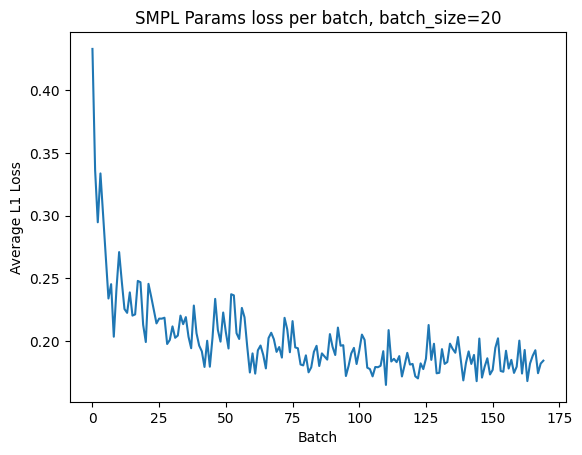

In [20]:
import matplotlib.pyplot as plt
import time

print(batch_losses)

plt.title(f"SMPL Params loss per batch, batch_size={batch_size}")
plt.xlabel("Batch")
plt.ylabel("Average L1 Loss")
plt.plot(np.arange(len(batch_losses)), batch_losses)

plt.savefig(f"Visualizations/multihmr_smpl_loss_per_batch_{time.time()}.png")

[0.26685212990816903, 0.21884342326837428, 0.2051856789518805, 0.20134608359897838, 0.19368897378444672, 0.19143663434421315, 0.18348421331714182, 0.18514796477906845, 0.18524631068987005, 0.18246672609273126]


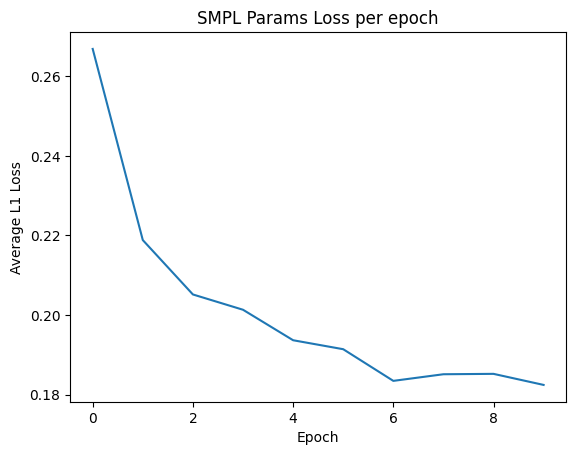

In [44]:
import matplotlib.pyplot as plt

print(epoch_losses)

plt.title("SMPL Params Loss per epoch")
plt.xlabel("Epoch")
plt.ylabel("Average L1 Loss")
plt.plot(np.arange(len(epoch_losses)), epoch_losses)

plt.savefig(f"Visualizations/multihmr_smpl_loss_per_epoch_{time.time()}.png")

# Infer on new image

In [43]:
img_size = model.img_size
x, img_pil_nopad = open_image(os.path.join("field_image", "field.png"), img_size)   
x = torch.tensor(x).to(device)
# Get camera parameters
p_x, p_y = None, None
K = get_camera_parameters(model.img_size, fov=60, p_x=p_x, p_y=p_y)

humans = forward_model(model, x, K, 
                       det_thresh=0.3,
                       nms_kernel_size=1)

img_array = np.asarray(img_pil_nopad)
img_pil_visu= Image.fromarray(img_array)
pred_rend_array, _color = overlay_human_meshes(humans, K, model, img_pil_visu, unique_color=0)

Image.fromarray(pred_rend_array).save("inferred_image.png")
